In [1]:
# import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import grad

import matplotlib.pyplot as plt

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [2]:
# import and login Weights and Baises
import wandb
!wandb login

wandb: Currently logged in as: adisiddharth (use `wandb login --relogin` to force relogin)


In [3]:
# Initialize wandb project
wandb.init(project = 'Captum Pytorch')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: adisiddharth (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [4]:
#set cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Read in train dataset
train = pd.read_csv('Endometriosis_subset_train_feature_extract.csv')

In [6]:
# Set index to IDs
train.set_axis(train['meth_id'], inplace = True)

In [7]:
# Drop the ID cols 
cols_drop = ['meth_id', 'meth_id.1']
train.drop(columns=cols_drop, inplace = True)

In [8]:
# Change Endo Yes/No to binary
train['Endometriosis_int'] = np.where(train['Endometriosis'] == 'Yes', 1, train['Endometriosis'])
train['Endometriosis_int'] = np.where(train['Endometriosis_int'] == 'No', 0, train['Endometriosis_int'])

In [9]:
# Comment out to remove Cycle Phase from features
train = train.join(pd.get_dummies(train['Cycle_Phase']))
y_train = train.pop('Endometriosis_int')
x_train = train.iloc[:, 5:-3]

In [10]:
# read val dataset
val = pd.read_csv('Endometriosis_subset_test_feature_extract.csv')

In [11]:
#set index to IDs
val = val.set_axis(val['meth_id'])

In [12]:
# Group ESE, MSE and LSE into SE 
val.loc[val['Cycle_Phase'].isin(['ESE', 'MSE', 'LSE']), 'Cycle_Phase'] = 'SE'

In [13]:
# Comment out to remove Cycle Phase from features
val = val.join(pd.get_dummies(val['Cycle_Phase']))
y_val = val.pop('Endometriosis_int')
x_val = val.iloc[:, 6:-3]

In [14]:
# join val and train
x_train_full = pd.concat([x_train, x_val])

In [15]:
y_train_full = pd.concat([y_train, y_val])

In [16]:
# read test dataset
test = pd.read_csv('Endometriosis_subset_test2_feature_extract.csv')

In [17]:
# Assign index as IDs
test.set_index('meth_id', inplace = True)

In [18]:
# Comment out to remove Cycle Phase from features
test = test.join(pd.get_dummies(test['Cycle_Phase']))
y_test = test.pop('Endometriosis_int')
x_test = test.iloc[:, 5:-3]

In [19]:
# Set train and test features and labels
train_features = x_train_full.to_numpy()
train_labels = y_train_full.to_numpy(dtype=np.int64)
test_features = x_test.to_numpy()
test_labels = y_test.to_numpy(dtype=np.int64)

In [20]:
train_features.shape, test_features.shape, test_labels.shape, train_labels.shape

((992, 45188), (52, 45188), (52,), (992,))

In [21]:
# Set hyperparameters
lr=0.0001 
optimizer = "Adam"
num_epochs = 500
loss = 'BCE'
nodes = 650
activation1 = 'relu'
activation2 = 'softmax'

In [22]:
# Set up config (columns) to record in wandb
run_config = {'lr': lr, 'optimizer': optimizer, 'epochs': num_epochs, 'nodes': nodes, 'activation1': activation1, 'activation2': activation2, 'loss': loss}
wandb_run = wandb.init(project='Captum Pytorch', config=run_config)

wandb: wandb version 0.12.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [23]:
torch.manual_seed(1)  # Set seed for reproducibility.


if activation1 == 'relu':    
    activation1 = nn.ReLU()
elif activation1 == 'elu':    
    activation1 = nn.ELU()
elif activation1 == 'selu':    
    activation1 = nn.SELU()
elif activation1 == 'sigmoid':    
    activation1 = nn.Sigmoid()
if activation2 == 'sigmoid':    
    activation2 = nn.Sigmoid()
elif activation2 == 'relu':    
    activation2 = nn.ReLU()
elif activation2 == 'softmax':    
    activation2 = nn.Softmax()
    
# Model
class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(train_features.shape[1], nodes)
        self.relu1 = activation1
        self.linear2 = nn.Linear(nodes, nodes)
        self.relu2 = activation1
        self.linear3 = nn.Linear(nodes, nodes)
        self.relu3 = activation1
        self.linear4 = nn.Linear(nodes, nodes)
        self.relu4 = activation1
        self.linear5 = nn.Linear(nodes, nodes)
        self.relu5 = activation1
        self.linear6 = nn.Linear(nodes, nodes)
        self.relu6 = activation1
        self.linear7 = nn.Linear(nodes, nodes)
        self.relu7 = activation1
        self.linear8 = nn.Linear(nodes, nodes)
        self.relu8 = activation1
        self.linear9 = nn.Linear(nodes, nodes)
        self.relu9 = activation1
        self.linear10 = nn.Linear(nodes, 2)
        self.relu10 = activation2

    def forward(self, x):
        out1 = self.linear1(x)
        out2 = self.relu1(out1)
        out3 = self.relu2(self.linear2(out2))
        out4 = self.relu3(self.linear3(out3))
        out5 = self.relu4(self.linear4(out4))
        out6 = self.relu5(self.linear5(out5))
        out7 = self.relu6(self.linear6(out6))
        out8 = self.relu7(self.linear7(out7))
        out9 = self.relu8(self.linear8(out8))
        out10 = self.relu9(self.linear9(out9))
        out11 = self.relu10(self.linear10(out10))
        return out11
        

net = TitanicSimpleNNModel()

# train loop
input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
label_tensor = torch.from_numpy(train_labels)
for epoch in range(num_epochs):    
    output = net(input_tensor)
    if loss == 'MAE':
        criterion = nn.L1Loss()
    elif loss == 'CrossEntropyLoss':    
        criterion = nn.CrossEntropyLoss()
    elif loss == 'MSE':    
        criterion = nn.MSELoss()
    elif loss == 'BCE':    
        criterion = nn.BCELoss()
    criterion = nn.CrossEntropyLoss()
    loss = criterion(output, label_tensor)
    if optimizer == 'Adam':
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    elif optimizer == 'Adamax':
        optimizer = torch.optim.Adamax(net.parameters(), lr=lr)
    elif optimizer == 'Adagrad':
        optimizer = torch.optim.Adagrad(net.parameters(), lr=lr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))
    
    #record loss every epoch in wandb    
    wandb_run.log({'loss': loss})
        
input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)

<ipython-input-23-a902ae70982f>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out11 = self.relu10(self.linear10(out10))


Epoch 1/500 => Loss: 0.69
Epoch 51/500 => Loss: 0.64
Epoch 101/500 => Loss: 0.60
Epoch 151/500 => Loss: 0.41
Epoch 201/500 => Loss: 0.40
Epoch 251/500 => Loss: 0.39
Epoch 301/500 => Loss: 0.35
Epoch 351/500 => Loss: 0.47
Epoch 401/500 => Loss: 0.38
Epoch 451/500 => Loss: 0.34


In [24]:
out_probs_train = net(input_tensor).detach().numpy()
out_classes_train = np.argmax(out_probs_train, axis=1)
train_acc = sum(out_classes_train == train_labels) / len(train_labels)
print("Train Accuracy:", train_acc)

Train Accuracy: 0.9758064516129032


<ipython-input-23-a902ae70982f>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out11 = self.relu10(self.linear10(out10))


In [25]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs_test = net(test_input_tensor).detach().numpy()
out_classes_test = np.argmax(out_probs_test, axis=1)
test_acc = sum(out_classes_test == test_labels) / len(test_labels)
print("Test Accuracy:", test_acc)

Test Accuracy: 0.7307692307692307


<ipython-input-23-a902ae70982f>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out11 = self.relu10(self.linear10(out10))


In [26]:
r_probs = [0 for _ in range(len(y_test))]

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score
#Random chance ROC
r_auc = roc_auc_score(y_test, r_probs)
r_fpr, r_tpr, _ = roc_curve(test_labels, r_probs)

#Test ROC
fpr, tpr, _ = roc_curve(test_labels, out_classes_test)
auc = roc_auc_score(test_labels, out_classes_test)

#Train ROC
tr_fpr, tr_tpr, _ = roc_curve(train_labels, out_classes_train)
tr_auc = roc_auc_score(train_labels, out_classes_train)

# External Test ROC
#ext_fpr, ext_tpr, _ = roc_curve(y_test2, pred_ext)
#ext_auc = roc_auc_score(y_test2, pred_ext)

In [28]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Test Prediction: AUROC = %.3f' % (auc))
print('Train Prediction: AUROC = %.3f' % (tr_auc))
#print('External Test Prediction: AUROC = %.3f' % (ext_auc))

Random (chance) Prediction: AUROC = 0.500
Test Prediction: AUROC = 0.718
Train Prediction: AUROC = 0.971


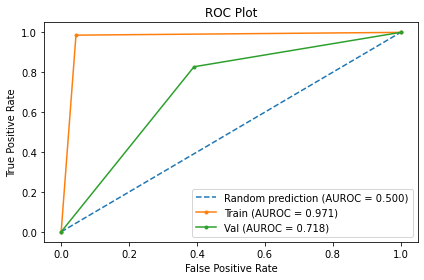

In [29]:
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(tr_fpr, tr_tpr, marker='.', label='Train (AUROC = %0.3f)' % tr_auc)
plt.plot(fpr, tpr, marker='.', label='Val (AUROC = %0.3f)' % auc)
#plt.plot(ext_fpr, ext_tpr, marker='.', label='Ext Test (AUROC = %0.3f)' % ext_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend(loc = 'lower right', prop={'size': 10}) 
plt.tight_layout()
#plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'ROC_Curve' + kfold + '.png', bbox_inches = "tight")

In [30]:
# record more metrics in wandb
wandb_run.log({'auc': auc, 'train_accuracy': train_acc, 'test_accuracy': test_acc})

In [31]:
# set up integrated gradients 
ig = IntegratedGradients(net)

In [32]:
test_input_tensor.shape

torch.Size([52, 45188])

In [34]:
# obtain integrated gradient attributes
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

<ipython-input-23-a902ae70982f>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out11 = self.relu10(self.linear10(out10))


In [35]:
# get cpg islands
feature_names = x_train.columns

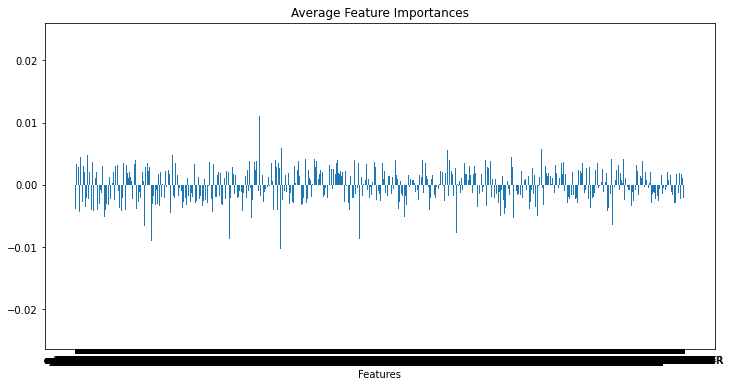

In [36]:
# Plot relative importance of cpg islands
attributes = pd.DataFrame()
cpg = []
imp = []
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    #print(title)
    for i in range(len(feature_names)):
        #print(feature_names[i], ": ", '%.3f'%(importances[i]))
        cpg.append(feature_names[i])
        imp.append(importances[i])
    
    
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
attributes['CPG'] = cpg
attributes['Attributes'] = imp
visualize_importances(feature_names, np.mean(attr, axis=0))

In [39]:
# collate data into dataframe
attributes['CPG'] = cpg
attributes['Attributes'] = imp
attributes['Attributes Sq'] = attributes['Attributes']**2 # square values to get only get magnitude of importance

In [40]:
attributes

,CPG,Attributes,Attributes Sq
0,cg10148841,-0.002870,0.000008
1,cg21351005,-0.001221,0.000001
2,cg07701590,0.004266,0.000018
3,cg13630693,-0.002962,0.000009
4,cg16774853,0.005439,0.000030
...,...,...,...
45183,cg27232569,0.001684,0.000003
45184,cg21012362,0.004069,0.000017
45185,cg07834475,0.001681,0.000003
45186,cg03968010,0.001214,0.000001


In [41]:
attributes.describe()

,Attributes,Attributes Sq
count,45188.000000,4.518800e+04
mean,0.000004,6.334756e-06
std,0.002517,1.155228e-05
min,-0.023956,1.721239e-14
25%,-0.001839,1.174958e-06
50%,-0.000044,3.440069e-06
75%,0.001868,7.729281e-06
max,0.023668,5.738660e-04


In [42]:
attributes = attributes.sort_values(by = ['Attributes Sq'], ascending = False)
attributes

,CPG,Attributes,Attributes Sq
7417,cg13498216,-2.395550e-02,5.738660e-04
3311,cg22153345,2.366808e-02,5.601779e-04
12191,cg20389709,-2.356464e-02,5.552922e-04
15092,cg13311805,-2.265269e-02,5.131442e-04
30565,cg04295700,-1.720729e-02,2.960908e-04
...,...,...,...
28253,cg00784882,3.750090e-07,1.406317e-13
20396,cg22763905,3.202682e-07,1.025717e-13
41373,cg15479262,-3.113435e-07,9.693480e-14
40891,cg01693638,2.454559e-07,6.024859e-14


In [43]:
attributes.iloc[:100,:].to_csv('Top100_CPG_IG_Captum.csv')

In [50]:
# read in top 500 cpg islands from tensorflow feature importance permutation 
data = pd.read_csv('top_500_cpg_islands.txt', sep=" ", header=None)
data

,0
0,cg10847607
1,cg01455177
2,cg06746652
3,cg11490836
4,cg06679270
...,...
495,cg15420678
496,cg17529006
497,cg17999327
498,cg00238023


In [51]:
cpg_fip = data[0]

In [52]:
cpg_captum = attributes['CPG'].to_list()

In [53]:
cpg_fip = data[0].to_list()

In [54]:
intersect = list(set(cpg_captum) & set(cpg_fip)) # check intersect of cpg islands from Captum and feature importance permutation 

In [55]:
len(intersect) # no. of intersecting cpg islands

500